## Estimation of soil water content in the entire root-zone

**Name**: Pedro Rossini <br/>
**Project area**: Agronomy - soil water ralations

## Objective
Implement in python an exponential filter equation to estimate daily soil water content (SWC) of the entire root-zone from surface observations.

## Motivation and Methodology

Water stress is considered one of the main limiting factors in summer crop yield. Monitoring SWC during the crop seasson is a key factor to improve the management in irrigation systems and reduce the yield gaps. 

The exponential filter is a known analytical method, that divide the soil profile in two layers: surface (first layer) and sub-surface (second layer). The objetive is to predict the sub-surface soil moisture from observed measurement from the surface layer (Wagner et al., 1999).  

Albergel et. al., (2008) presented a recursive equation to simplify the calculations:


  $$SWI_{2(t)} = SWI_{2(t-1)} + K_t [\text{vwc}_{(t)} - SWI_{2(t-1)}]$$
  
Where $SWI_2$ represent the soil water index of the second layer, $\text vwc_{(t)}$ represents the measured soil moisture at the surface layer, $K$ is the gain of the exponential filter that gets values between 0 and 1, and $t$ is the day of measurement. $SWI_2$ is a scaled soil moisture content and ranges between 0 to 1 based on the minimum and maximum values of each time series.  

In order to get the profile soil water content (profile_SWC) is necessary to re-scale the $SWI_2$ by using the maximum and minimum soil moisture from the second layer and then adding the soil moisture measured on the first layer.

The initial $SWI_2$ (t=1) will be estimated using soil moisture observations from a Mesonet station (0-5 cm depth) divided by the maximum amount of water that the layer can hold. 
The initial value for profile_$SWC$ (t=1) will be estimated using soil moisture observations from a Mesonet station (0-5 cm depth) and multiplied by the length of the first layer in millimeters plus the difference between the maximum and the minimum amount of water that the sub-surface layer can hold by the length of the second layer in millimeters.

In this work, daily soil moisture observations at 5 cm depth ($\text vwc_{(t)}$) from Kansas mesonet stations were used as model input to predict profile soil moisture from 0 to 50 cm depth (also know as root-zone). In addition, soil moisture observations at 10, 20, and 50 cm depth from Kansas mesonet stations were used to test the model outputs.

The model was tested in eight stations during 2018 between April to November because we are focused on testing the model during the summer crop season, and to avoid interference of freezing temperatures during the winter in soil moisture readings.

## Sketch
 
<img src="sketch.JPG" alt="sketch_image" width="700"/>

Figure 1. Sketch summary the workflow proposed for this project.

#### Import the modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Define a function to calculate daily profile Soil Water Content

In [39]:

def SWIfn (vwc5,surf_max,sub_surf_max,sub_surf_min,k):
    """"
    Calculates profile soil water content and Soil water index
    
    Inputs
    -vwc5 : Daily measured volumetric water content from a sensor at 5 cm depth (vol/vol)
    -surf_max : Maximun amount of water that surface layer can hold (vol/vol)
    -sub_surf_max : Maximun amount of water that sub-surface layer can hold (vol/vol)
    -sub_surf_min : Minimun amount of water that sub-surface layer can hold (vol/vol)
    -K : the gain of the exponential filter (in this case we are using a fixed value = 1)
    
    Outputs:
    profile_SWC : Daily profile soil water content (milimeters)
    SWI : Daily soil water index (dimensionless)
    
    Author:PR
    Date:16-Apr-2019
    """

    SWI = [(vwc5[0]/surf_max)] 
    profile_SWC = [((vwc5[0] * 50) + ((sub_surf_max-sub_surf_min) * 450))] 
    
    
    for i in range(1,len(vwc5)):
        #In case the input data present NaN values we solve it using the SWI and profile_SWC from the day before
        if np.isnan(vwc5[i]):
            new_SWI = SWI[i-1] * 0.95
            SWI.append(new_SWI)
            sub_surf_storage = SWI[i-1] * (sub_surf_max - sub_surf_min) + sub_surf_min
            profile_SWC_est = (vwc5[i-1] * 50) + (sub_surf_storage * 450)
            profile_SWC.append(profile_SWC_est)  
        
        #If the input data do not have NaN values run the exponential filter
        else:
            #Calculate daily SWI for the second layer from the observations of soil moisture in the first layer (vwc5[i])
            #The SWI is related with the previous day SWI and a gain factor K that we are using as a constant K = 1 
            new_SWI = SWI[i-1] + k *((vwc5[i]/surf_max) - SWI[i-1])
            SWI.append(new_SWI)
            
            #Using daily SWI calculated previously we estimate soil water content in the second layer 
            sub_surf_storage = SWI[i] * (sub_surf_max - sub_surf_min) + sub_surf_min
            
            #We add to soil water content in the first layer plus soil water content in the second layer
            profile_SWC_est = (vwc5[i] * 50) + (sub_surf_storage * 450)
            profile_SWC.append(profile_SWC_est)  

    return profile_SWC, SWI


#### Import data and defining inputs variables

- Data available to run the function:
    - Cherokee_2018_to_2019.csv
    - Colby_2018_to_2019.csv
    - GardenCity_2018_to_2019.csv
    - Gypsum_2018_to_2019.csv
    - Hays_2018_to_2019.csv
    - Hodgeman_2018_to_2019.csv
    - LakeCity_2018_to_2019.csv
    - Lane_2018_to_2019.csv

In [40]:
dirname = '/Users/prossini/Desktop/coding/Project_SWI/'
filname = 'Lane_2018_to_2019.csv'
mesonet_data = pd.read_csv(dirname + filname)

#From mesonet_data calculate variables to evaluate the exponential filter outputs
SWC5 = (mesonet_data.VWC5CM * 50).rolling(2, min_periods=1,center=True).mean()                 
SWC10 = (mesonet_data.VWC5CM  + mesonet_data.VWC10CM)/2 * 50
SWC20 = (mesonet_data.VWC10CM + mesonet_data.VWC20CM)/2 * 100
SWC50 = (mesonet_data.VWC20CM + mesonet_data.VWC50CM)/2 * 300 

profile_SWC_sensors = SWC5 + SWC10 + SWC20 + SWC50
sub_surface_SWC_sensors = SWC10 + SWC20 + SWC50;

#Create a range of dates for plotting results
dates = pd.date_range(mesonet_data.TIMESTAMP[0], periods=mesonet_data.shape[0], freq='d')
total_precip = round(mesonet_data.PRECIP.sum(),1)

#Defining inputs to run the function
vwc5 = mesonet_data.VWC5CM.rolling(2, min_periods=1,center=True).mean()     
surface_max = np.max(vwc5)                       
sub_surf_max = np.max(sub_surface_SWC_sensors)/450                  
sub_surf_min = np.min(sub_surface_SWC_sensors)/450

#### Execute the SWIfn function and calculate the agreement between measured and calculated values

In [41]:
profile_SWC,SWI = SWIfn(vwc5,surface_max,sub_surf_max,sub_surf_min,1)

#Calculate Root mean square error
RMSE = round(np.sqrt(np.mean((profile_SWC-profile_SWC_sensors)**2)),2)
#Calculate Mean absolute error
MAE = round(np.mean(np.abs(profile_SWC-profile_SWC_sensors)),2)

#### Ploting predicted vs observed profile soil moisture

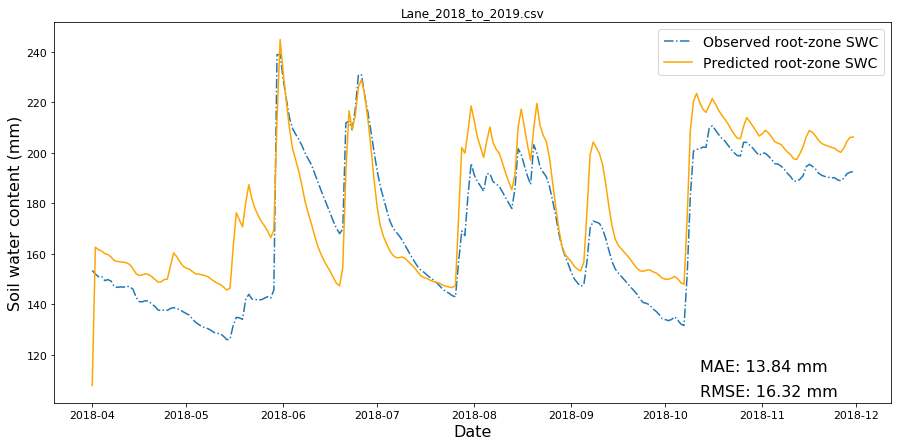

In [42]:
plt.figure(figsize=(15,7))

#observed data
plt.plot(dates,profile_SWC_sensors,'-.') 
#predicted data
plt.plot(dates,profile_SWC,'orange') 

#Define leged, axis labels,title
plt.legend(['Observed root-zone SWC','Predicted root-zone SWC'],fontsize=14)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Soil water content (mm)',fontsize=16)
plt.rcParams['ytick.labelsize'] = 11.0
plt.rcParams['xtick.labelsize'] = 11.0
plt.title(filname,  fontdict=None, loc='center', pad=None)

# Add information about model agreement
annotation_label = 'RMSE: ' + str(RMSE) + ' mm'
plt.annotate(annotation_label, xy=(700, 50), xycoords='figure points', fontsize=16)
annotation_label = 'MAE: ' + str(MAE) + ' mm'
plt.annotate(annotation_label, xy=(700, 75), xycoords='figure points', fontsize=16)
plt.show()

#### Ploting predicted root_zone SWC and precipitation

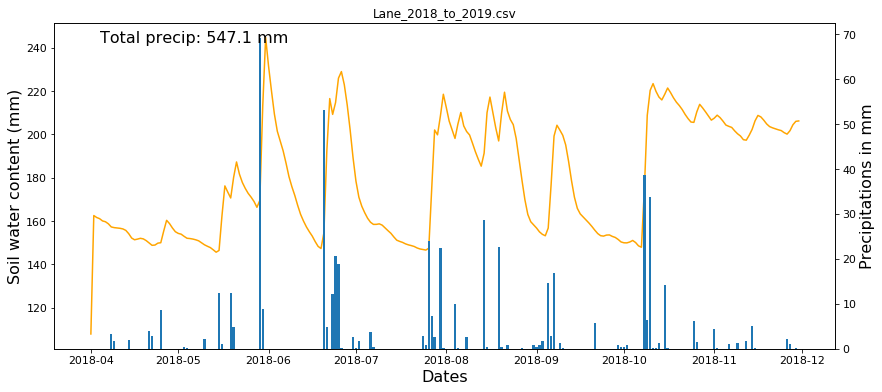

In [26]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot()
ax1.plot(dates,profile_SWC,'orange')
ax2 = ax1.twinx()
ax2.bar(dates,mesonet_data.PRECIP)

ax1.set_xlabel('Dates',fontsize=16)
ax1.set_ylabel('Soil water content (mm)', fontsize=16)
ax2.set_ylabel('Precipitations in mm', fontsize=16)
plt.title(filname,  fontdict=None, loc='center', pad=None)

# Add information
annotation_label = 'Total precip: ' + str(total_precip) + ' mm'
plt.annotate(annotation_label, xy=(100,350), xycoords='figure points', fontsize=16)
plt.show()

#### Preliminary results

- The model succesfully estimated the profile soil water content for differents scenarios (soil, weather) across Kansas for most of the Mesonet stations.
- Overall, RMSE and MAE oscilated between 6.6 and 20.6 mm, meaning an error between 6 to 12% in the entire soil profile. 
- The model was able to capture the response for different rates of rainfall event during the season.
-  For the stations were the model did not predict well, modifications in sub_surf_max parameter were done in order to achieve similar predictions to the other stations (data not showed)

#### Future work

- Identify the relation between SWI and subsurface water storage in different conditions to improve the model predictions where was not work properly 